In [ ]:
!echo "hello"

# load and view data

In [1]:
from __future__ import print_function, division
from collections import OrderedDict
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import time
from numpy import savez_compressed


torch.set_default_tensor_type(torch.cuda.FloatTensor)

x = np.load('data/gsn_img_uint8.npy')
y = np.load('data/gsn_msk_uint8.npy')

x_test = np.load('data/test_gsn_image.npy')
y_test = np.load('data/test_gsn_mask.npy')

In [2]:
print(x.shape, y.shape)

(2000, 128, 128, 3) (2000, 128, 128, 1)


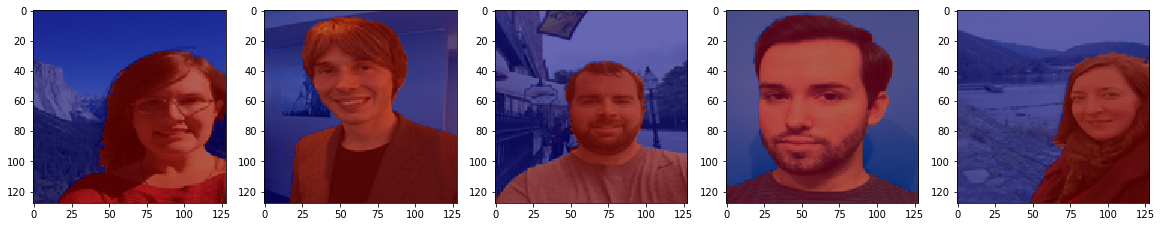

In [3]:
from matplotlib import pyplot as plt
torch.set_default_tensor_type(torch.cuda.FloatTensor)

def imshow(img):
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(img,aspect='auto')
    plt.show()

def imshow_many(imgs):
    n = imgs.shape[0]
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 10
        rows = int((n+9)/10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        if(imgs.shape[3] == 1) :
            imgs = imgs.reshape((imgs.shape[0], imgs.shape[1], imgs.shape[2]))
        sub.imshow(imgs[i], interpolation='nearest')

def imshow_masked(samples):
    n = len(samples)
    if n < 20 :
        cols = 5
        rows = int((n+4)/5)
        fig = plt.figure(figsize=(cols * 4, rows * 4))
    else :
        cols = 10
        rows = int((n+9)/10)
        fig = plt.figure(figsize=(cols * 2, rows * 2))
    
    for i in range(n):
        sub = fig.add_subplot(rows, cols, i + 1)
        image = samples[i]['image']
        mask = samples[i]['mask']
        if torch.is_tensor(image) :
            image = image.permute(1,2,0)
        if torch.is_tensor(mask) :
            mask = mask.permute(1,2,0)
        mask = mask.reshape((mask.shape[0], mask.shape[1]))
        sub.imshow(image, interpolation='nearest')
        sub.imshow(mask, interpolation='nearest', cmap='jet', alpha=0.6)
    
start = 0
end = 5
samples = [{'image' : a, 'mask' : b} for a,b in zip(x[start:end], y[start:end])]
imshow_masked(samples)

# Transforms

In [4]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        resized_mask = transform.resize(mask, (new_h, new_w))
        mask = (resized_mask > 0.5).astype(resized_mask.dtype)

        return {'image': img, 'mask': mask}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        mask = mask[top: top + new_h,
                      left: left + new_w]

        return {'image': image, 'mask': mask}
    
    
class HFlip(object):
    """Flip image horizontaly.
    """

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        return {'image': np.flip(image, 0), 'mask': np.flip(mask,0)}


def tf_rotate_cw(img):
    extra = 0
    if len(img.shape) == 4 :
        extra = 1
    return img.transpose(1 + extra,2 + extra).flip(1 + extra)

def tf_rotate_ccw(img):
    return tf_rotate_cw(tf_rotate_cw(tf_rotate_cw(img)))    
    
def tf_Hflip(img, cw=True):
    return img.flip(len(img.shape) - 1)
    
class Rotate(object):
    """Flip image horizontaly.
    """

    def __init__(self, clockwise=True):
        self.cw = clockwise
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        if self.cw :
            img_CW = image.swapaxes(1,0)[:,::-1,...]
            mask_CW = mask.swapaxes(1,0)[:,::-1,...]
            sample = {'image': img_CW, 'mask': mask_CW}
        
        else :
            img_CCW = image.swapaxes(1,0)
            mask_CCW = mask.swapaxes(1,0)
            sample = {'image': img_CCW, 'mask': mask_CCW}

        return sample

    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = TF.to_tensor(image.copy())
        
        mask = TF.to_tensor(mask.copy())
        return {'image': image.float(),
                'mask': mask.float()}

# **Dataset**

In [5]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
class myDataset(Dataset):
    """Images and masks dataset."""

    def __init__(self, gsn_img, gsn_mask, transform=None):
        """
        Args:
            gsn_img (np.array): numpy array of images
            gsn_mask (np.array): numpy array of masks
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images = gsn_img
        self.masks = gsn_mask
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        mask = self.masks[idx]

        sample = {'image': image, 'mask': mask}
        if self.transform:
            sample = self.transform(sample)
        return sample


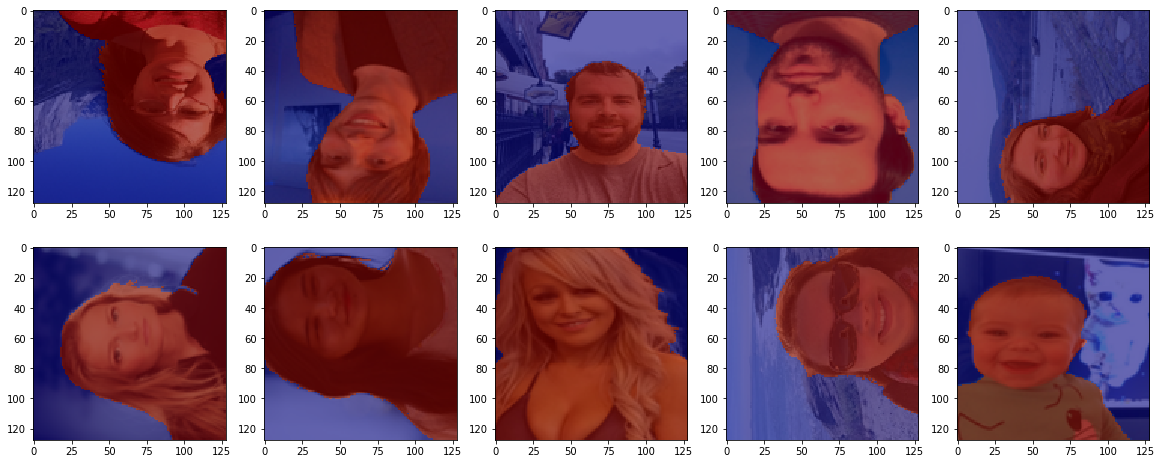

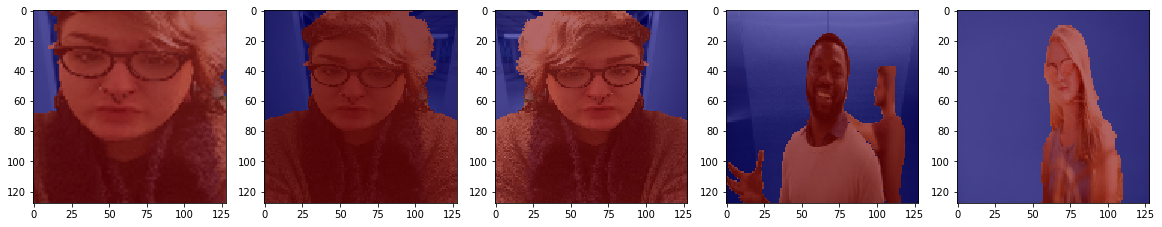

In [6]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

crop = transforms.Compose([Rescale(150),
                               RandomCrop(128)])
flip = HFlip()
rot_cw = Rotate()
rot_ccw = Rotate(clockwise=False)

all_transforms = transforms.Compose([
    transforms.RandomApply([crop], p=0.5),
    transforms.RandomApply([transforms.RandomChoice([flip, rot_cw, rot_ccw ])], p=0.7),
    ToTensor()])


toten = ToTensor()

numpy_dataset = myDataset(x, y)
train_dataset_aug = myDataset(x, y, transform=all_transforms)
test_dataset = myDataset(x_test, y_test, transform=toten)

# imshow_masked([train_dataset[i] for i in range(5)])

imshow_masked([train_dataset_aug[i] for i in range(10)])
imshow_masked([test_dataset[i] for i in range(5)])


In [7]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

trainloader = DataLoader(train_dataset_aug, batch_size=4,
                        shuffle=True, num_workers=0)
testloader = DataLoader(test_dataset, batch_size=4,
                        shuffle=True, num_workers=0)

torch.Size([4, 3, 128, 128])
torch.Size([4, 3, 128, 128])


tensor([[[0.6157, 0.6314, 0.6235,  ..., 0.6706, 0.6471, 0.6275],
         [0.5569, 0.5725, 0.6157,  ..., 0.7098, 0.6667, 0.6471],
         [0.5647, 0.5882, 0.6157,  ..., 0.6863, 0.6706, 0.6275],
         ...,
         [0.7412, 0.5961, 0.7412,  ..., 0.8078, 0.8196, 0.8078],
         [0.7686, 0.5843, 0.6941,  ..., 0.7922, 0.7765, 0.7961],
         [0.7451, 0.5686, 0.6706,  ..., 0.8157, 0.7882, 0.7961]],

        [[0.6235, 0.6314, 0.6275,  ..., 0.6588, 0.6235, 0.5961],
         [0.5333, 0.5529, 0.6118,  ..., 0.7020, 0.6471, 0.6118],
         [0.5412, 0.5725, 0.6039,  ..., 0.6745, 0.6549, 0.5882],
         ...,
         [0.7412, 0.5961, 0.7412,  ..., 0.8078, 0.8196, 0.8078],
         [0.7686, 0.5843, 0.6941,  ..., 0.7922, 0.7765, 0.7961],
         [0.7451, 0.5686, 0.6706,  ..., 0.8157, 0.7882, 0.7961]],

        [[0.6275, 0.6392, 0.6353,  ..., 0.6549, 0.6157, 0.5725],
         [0.5137, 0.5451, 0.6196,  ..., 0.7137, 0.6510, 0.5961],
         [0.5216, 0.5686, 0.6157,  ..., 0.6941, 0.6588, 0.

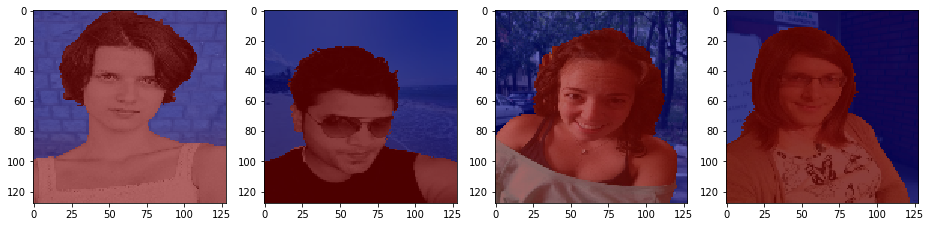

In [8]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

dataiter = iter(testloader)
one_data = dataiter.next()
img_batch = one_data['image']
mask_batch = one_data['mask']
print(img_batch.shape)
img_batch = tf_rotate_ccw(tf_rotate_cw(img_batch))
print(img_batch.shape)
# mask_batch = tf_Hflip(mask_batch)

imshow_masked([{'image':img_batch[i], 'mask':mask_batch[i]} for i in range(4)])
img_batch[0]

# Network

In [9]:
tsf = [(tf_rotate_cw, tf_rotate_ccw), (tf_rotate_ccw, tf_rotate_cw), (tf_Hflip, tf_Hflip)]
torch.set_default_tensor_type(torch.cuda.FloatTensor)

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=16):
        super(UNet, self).__init__()
        self.augumented = False
        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )
    
    def set_augumented(self, val):
        self.augumented = val
    
    def forward(self, x):
        if self.augumented :
            print("dupa")
            no_aug = self.fwd(image)
            for (tr, rev_tr) in tsf :
                no_aug += rev_tr(self.fwd(tr(image)))
            return no_aug / (len(tsf) + 1)
        else :
            return self.fwd(x)
            
    def fwd(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

# Training

In [12]:
epochs = 10
lr = 0.0001
torch.set_default_tensor_type(torch.cuda.FloatTensor)

def log_loss_summary(loss, step, prefix=""):
    print("epoch {} | {}: {}".format(step + 1, prefix + "loss", np.mean(loss)))



class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 1.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
            y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

def IOU(preds, truth):
    intersection = np.logical_and((preds > 0.5) == True,(truth > 0.5) == True).sum().item()
    union = (np.logical_or((preds > 0.5),(truth > 0.5))).sum().item()
    return intersection/union
    

imgs_log = []
    
unet = UNet(in_channels=3, out_channels=1).float()


crop = transforms.Compose([Rescale(150), RandomCrop(128)])
rot_cw = Rotate(True)
rot_ccw = Rotate(False)
flip = HFlip()



        


def train_validate():
    device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")
    
    unet.to(device)
    
    optimizer = optim.Adam(unet.parameters(), lr=lr)
    
    loss_train_log = []
    loss_valid_log = []
    IOU_log = []
    
    loss_train = []
    loss_valid = []
    
    dsc_loss = DiceLoss()
    
    step = 0
    
    start_train= time.time()
    for epoch in range(epochs):
        start_epoch = time.time()
        for phase in ["train", "valid"]:
            if phase == "train":
                unet.train()
            else:
                unet.eval()
    
            validation_pred = []
            validation_true = []
            IOU_avg_sum = 0
            batches = 0
    
            for i, data in enumerate(trainloader, 0):
                if phase == "train":
                    step += 1
                
                x = data['image']
                y_true = data['mask']
                
                
                
                x, y_true = x.to(device), y_true.to(device)
    
                optimizer.zero_grad()
    
                with torch.set_grad_enabled(phase == "train"):
                    y_pred = unet(x)
                    
                    loss = dsc_loss(y_pred, y_true)
                    
                    if phase == "valid":
                        loss_valid.append(loss.item())
                        y_pred_np = y_pred.detach().cpu().numpy()
                        validation_pred.extend(
                            [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                        )
                        y_true_np = y_true.detach().cpu().numpy()
                        validation_true.extend(
                            [y_true_np[s] for s in range(y_true_np.shape[0])]
                        )
                        
                        imgs_log.append((y_true_np[0],y_pred_np[0]))
                        
                        batch_size = y_pred_np.shape[0]
                        IOU_batch = [IOU(y_pred_np[i],y_true_np[i]) for i in range(batch_size) ]
                        IOU_avg_sum += sum(IOU_batch)/batch_size
                        batches += 1
                        
                    if phase == "train":
                        loss_train.append(loss.item())
                        loss.backward()
                        optimizer.step()
    
            if phase == "train":
                loss_train_log.append(np.mean(loss_train))
                log_loss_summary(loss_train, epoch)
                loss_train = []

            if phase == "valid":
                iou = IOU_avg_sum/batches
                print("IOU=", iou)
                IOU_log.append(iou)
                loss_valid_log.append(np.mean(loss_valid))
                log_loss_summary(loss_valid, epoch, prefix="val_")
                loss_valid = []
        end_epoch = time.time()
        total_so_far = (end_epoch - start_train)
        time_per_epoch = total_so_far / (epoch + 1)
        eta = (epochs - epoch - 1) * time_per_epoch
        print("total:{0}\tepoch{1}:{2}\tavg_per_epoch{3}\tETA:{4}".format(total_so_far, (epoch + 1), (end_epoch - start_epoch),time_per_epoch, eta))
    return loss_train_log,loss_valid_log, IOU_log
    

In [ ]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)

start = time.time()

train_log,test_log, iou_log =  train_validate()

end = time.time()
elapsed = end - start
print("elapsed", elapsed)

plt.plot(train_log, label='train')
plt.plot(test_log, label='test')
plt.title("loss vs epoch")
plt.legend()
plt.show()

plt.plot(iou_log, label="IOU")
plt.title("IOU on test set vs epoch")
plt.show()

torch.save(unet.state_dict(), 'model30_noaug.mod')
# save to npy file
savez_compressed('train_log.npz', np.array(train_log))
savez_compressed('test_log.npz', np.array(test_log))
savez_compressed('iou_log.npz', np.array(iou_log))


epoch 1 | loss: 0.2984634172916412
IOU= 0.7192667452760539
epoch 1 | val_loss: 0.25754389715194703
total:64.83734440803528	epoch1:64.83734440803528	avg_per_epoch64.83734440803528	ETA:583.5360996723175
epoch 2 | loss: 0.21815810477733613
IOU= 0.7852906218493104
epoch 2 | val_loss: 0.19166558027267455
total:134.39611339569092	epoch2:69.55876898765564	avg_per_epoch67.19805669784546	ETA:537.5844535827637
epoch 3 | loss: 0.17743035042285918
IOU= 0.7821437594147091
epoch 3 | val_loss: 0.1725333024263382
total:201.1575047969818	epoch3:66.7613914012909	avg_per_epoch67.05250159899394	ETA:469.3675111929576
epoch 4 | loss: 0.1467453850507736
IOU= 0.8292380861831815
epoch 4 | val_loss: 0.1308128455877304
total:267.64015078544617	epoch4:66.48264598846436	avg_per_epoch66.91003769636154	ETA:401.46022617816925
epoch 5 | loss: 0.12488173592090607
IOU= 0.8413134413976106
epoch 5 | val_loss: 0.11319316446781158
total:335.4290919303894	epoch5:67.78894114494324	avg_per_epoch67.08581838607788	ETA:335.429091

# Results

In [ ]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

unet = UNet(in_channels=3, out_channels=1)
unet.load_state_dict(torch.load('model30_noaug.mod'))
unet.to(device)
print("loaded")

In [ ]:
tsf = [(tf_rotate_cw, tf_rotate_ccw), (tf_rotate_ccw, tf_rotate_cw), (tf_Hflip, tf_Hflip)]

def augumentedPred(image, unet):
    no_aug = unet(image)
    
    for (tr, rev_tr) in tsf :
        no_aug += rev_tr(unet(tr(image)))
    return no_aug / (len(tsf) + 1)

In [ ]:
unet.set_augumented(False)

In [ ]:
dataiter = iter(trainloader)
one_data = dataiter.next()
image = one_data['image'].to(device)
y_true = one_data['mask'].to(device)

In [ ]:
unet.set_augumented(False)
y_pred = unet(image)

imshow_masked([{'image':image[0].cpu(), 'mask':y_true[0].cpu()}])
imshow_masked([{'image':image[0].detach().cpu(), 'mask':y_pred[0].detach().cpu()}])


tr, rev_tr = tsf[0]
y_pred2 = unet(tr(image))

imshow_masked([{'image':tr(image)[0].detach().cpu(), 'mask':y_pred2[0].detach().cpu()}])

In [ ]:
dataiter = iter(trainloader)
one_data = dataiter.next()
image = one_data['image'].to(device)
y_true = one_data['mask'].to(device)

unet.set_augumented(False)
y_pred = unet(image)

imshow_masked([{'image':image[i].cpu(), 'mask':y_true[i].cpu()} for i in range(4)])
imshow_masked([{'image':image[i].cpu(), 'mask':y_pred[i].detach().cpu()} for i in range(4)])

unet.set_augumented(True)
y_pred2 = unet(image)

imshow_masked([{'image':image[i].cpu(), 'mask':y_pred2[i].detach().cpu()} for i in range(4)])